In [ ]:
# Imports
import numpy as np
import os
from utils.utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline    

ModuleNotFoundError: No module named 'utils'

In [ ]:
X_train, labels_train, list_ch_train = read_data(data_path="datas", split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path="datas", split="test") # test
assert list_ch_train == list_ch_test, "Mistmatch in channels!"


In [10]:
# Standardize
X_train, X_test = standardize(X_train, X_test)

In [11]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train,
                                                random_state = 123)

In [12]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

In [13]:
# Imports
import tensorflow as tf

lstm_size = 6        # 3 times the amount of channels
lstm_layers = 2        # Number of layers
batch_size = 100       # Batch size 
seq_len = 6          # Number of steps
learning_rate = 0.0001  # Learning rate (default is 0.001)
epochs = 2000

# Fixed
n_classes = 5
n_channels = 1

In [14]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

In [15]:
with graph.as_default():
    # Construct the LSTM inputs and LSTM cells
    lstm_in = tf.transpose(inputs_, [1,0,2]) # reshape into (seq_len, N, channels)
    lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
    
    # To cells
    lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?
    print(lstm_in)
    # Open up the tensor into a list of seq_len pieces
    lstm_in = tf.split(lstm_in, seq_len, 0)
    
    # Add LSTM layers
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    initial_state = cell.zero_state(batch_size, tf.float32)

Tensor("dense/BiasAdd:0", shape=(?, 6), dtype=float32)


In [16]:
with graph.as_default():
    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32,
                                                     initial_state = initial_state)
    
    # We only need the last output tensor to pass into a classifier
    logits = tf.layers.dense(outputs[-1], n_classes, name='logits')
    print(logits)
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    #optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost) # No grad clipping
    
    # Grad clipping
    train_op = tf.train.AdamOptimizer(learning_rate_)

    gradients = train_op.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
    optimizer = train_op.apply_gradients(capped_gradients)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Tensor("logits/BiasAdd:0", shape=(100, 5), dtype=float32)


In [17]:
if (os.path.exists(r'D:\py_projects\ML\ML_Demo\financial\checkpoints') == False):
    !mkdir checkpoints

In [22]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    
    for e in range(epochs):
        # Initialize 
        state = sess.run(initial_state)
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, 
                    initial_state : state, learning_rate_ : learning_rate}
            
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], 
                                             feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 25 iterations
            if (iteration%25 == 0):
                
                # Initiate for validation set
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                
                val_acc_ = []
                val_loss_ = []
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0, initial_state : val_state}
                    
                    # Loss
                    loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict = feed)
                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    #save model
    saver.save(sess,"checkpoints/credit-grade-cnn-lstm.ckpt")

Epoch: 1/2000 Iteration: 5 Train loss: 1.609823 Train acc: 0.260000
Epoch: 3/2000 Iteration: 10 Train loss: 1.606755 Train acc: 0.330000
Epoch: 4/2000 Iteration: 15 Train loss: 1.612811 Train acc: 0.270000
Epoch: 6/2000 Iteration: 20 Train loss: 1.606123 Train acc: 0.370000
Epoch: 8/2000 Iteration: 25 Train loss: 1.607410 Train acc: 0.390000
Epoch: 8/2000 Iteration: 25 Validation loss: 1.607290 Validation acc: 0.470000
Epoch: 9/2000 Iteration: 30 Train loss: 1.607510 Train acc: 0.250000
Epoch: 11/2000 Iteration: 35 Train loss: 1.605771 Train acc: 0.330000
Epoch: 13/2000 Iteration: 40 Train loss: 1.604806 Train acc: 0.370000
Epoch: 14/2000 Iteration: 45 Train loss: 1.602869 Train acc: 0.310000
Epoch: 16/2000 Iteration: 50 Train loss: 1.609887 Train acc: 0.310000
Epoch: 16/2000 Iteration: 50 Validation loss: 1.604394 Validation acc: 0.490000
Epoch: 18/2000 Iteration: 55 Train loss: 1.605551 Train acc: 0.430000
Epoch: 19/2000 Iteration: 60 Train loss: 1.604468 Train acc: 0.300000
Epoch: 2

Epoch: 158/2000 Iteration: 475 Validation loss: 1.534724 Validation acc: 0.490000
Epoch: 159/2000 Iteration: 480 Train loss: 1.515184 Train acc: 0.390000
Epoch: 161/2000 Iteration: 485 Train loss: 1.538724 Train acc: 0.370000
Epoch: 163/2000 Iteration: 490 Train loss: 1.514103 Train acc: 0.480000
Epoch: 164/2000 Iteration: 495 Train loss: 1.514095 Train acc: 0.440000
Epoch: 166/2000 Iteration: 500 Train loss: 1.558004 Train acc: 0.280000
Epoch: 166/2000 Iteration: 500 Validation loss: 1.528930 Validation acc: 0.490000
Epoch: 168/2000 Iteration: 505 Train loss: 1.521913 Train acc: 0.470000
Epoch: 169/2000 Iteration: 510 Train loss: 1.508233 Train acc: 0.330000
Epoch: 171/2000 Iteration: 515 Train loss: 1.544396 Train acc: 0.330000
Epoch: 173/2000 Iteration: 520 Train loss: 1.517615 Train acc: 0.460000
Epoch: 174/2000 Iteration: 525 Train loss: 1.491978 Train acc: 0.350000
Epoch: 174/2000 Iteration: 525 Validation loss: 1.523246 Validation acc: 0.490000
Epoch: 176/2000 Iteration: 530 Tra

Epoch: 316/2000 Iteration: 950 Validation loss: 1.421172 Validation acc: 0.490000
Epoch: 318/2000 Iteration: 955 Train loss: 1.437831 Train acc: 0.490000
Epoch: 319/2000 Iteration: 960 Train loss: 1.435058 Train acc: 0.400000
Epoch: 321/2000 Iteration: 965 Train loss: 1.536153 Train acc: 0.300000
Epoch: 323/2000 Iteration: 970 Train loss: 1.405001 Train acc: 0.480000
Epoch: 324/2000 Iteration: 975 Train loss: 1.422584 Train acc: 0.420000
Epoch: 324/2000 Iteration: 975 Validation loss: 1.415518 Validation acc: 0.490000
Epoch: 326/2000 Iteration: 980 Train loss: 1.477592 Train acc: 0.350000
Epoch: 328/2000 Iteration: 985 Train loss: 1.385655 Train acc: 0.550000
Epoch: 329/2000 Iteration: 990 Train loss: 1.383868 Train acc: 0.420000
Epoch: 331/2000 Iteration: 995 Train loss: 1.463278 Train acc: 0.370000
Epoch: 333/2000 Iteration: 1000 Train loss: 1.399205 Train acc: 0.450000
Epoch: 333/2000 Iteration: 1000 Validation loss: 1.409783 Validation acc: 0.490000
Epoch: 334/2000 Iteration: 1005 

Epoch: 474/2000 Iteration: 1425 Validation loss: 1.339332 Validation acc: 0.490000
Epoch: 476/2000 Iteration: 1430 Train loss: 1.446321 Train acc: 0.390000
Epoch: 478/2000 Iteration: 1435 Train loss: 1.336973 Train acc: 0.520000
Epoch: 479/2000 Iteration: 1440 Train loss: 1.316692 Train acc: 0.470000
Epoch: 481/2000 Iteration: 1445 Train loss: 1.494753 Train acc: 0.300000
Epoch: 483/2000 Iteration: 1450 Train loss: 1.321001 Train acc: 0.490000
Epoch: 483/2000 Iteration: 1450 Validation loss: 1.335694 Validation acc: 0.490000
Epoch: 484/2000 Iteration: 1455 Train loss: 1.318386 Train acc: 0.450000
Epoch: 486/2000 Iteration: 1460 Train loss: 1.491572 Train acc: 0.390000
Epoch: 488/2000 Iteration: 1465 Train loss: 1.348274 Train acc: 0.460000
Epoch: 489/2000 Iteration: 1470 Train loss: 1.369967 Train acc: 0.430000
Epoch: 491/2000 Iteration: 1475 Train loss: 1.433221 Train acc: 0.350000
Epoch: 491/2000 Iteration: 1475 Validation loss: 1.332370 Validation acc: 0.490000
Epoch: 493/2000 Itera

Epoch: 633/2000 Iteration: 1900 Validation loss: 1.292067 Validation acc: 0.490000
Epoch: 634/2000 Iteration: 1905 Train loss: 1.348620 Train acc: 0.410000
Epoch: 636/2000 Iteration: 1910 Train loss: 1.402141 Train acc: 0.350000
Epoch: 638/2000 Iteration: 1915 Train loss: 1.292087 Train acc: 0.500000
Epoch: 639/2000 Iteration: 1920 Train loss: 1.333273 Train acc: 0.450000
Epoch: 641/2000 Iteration: 1925 Train loss: 1.448124 Train acc: 0.330000
Epoch: 641/2000 Iteration: 1925 Validation loss: 1.290272 Validation acc: 0.490000
Epoch: 643/2000 Iteration: 1930 Train loss: 1.262250 Train acc: 0.500000
Epoch: 644/2000 Iteration: 1935 Train loss: 1.250468 Train acc: 0.480000
Epoch: 646/2000 Iteration: 1940 Train loss: 1.443393 Train acc: 0.290000
Epoch: 648/2000 Iteration: 1945 Train loss: 1.358964 Train acc: 0.490000
Epoch: 649/2000 Iteration: 1950 Train loss: 1.382288 Train acc: 0.370000
Epoch: 649/2000 Iteration: 1950 Validation loss: 1.288641 Validation acc: 0.490000
Epoch: 651/2000 Itera

Epoch: 791/2000 Iteration: 2375 Validation loss: 1.266842 Validation acc: 0.490000
Epoch: 793/2000 Iteration: 2380 Train loss: 1.249048 Train acc: 0.460000
Epoch: 794/2000 Iteration: 2385 Train loss: 1.365304 Train acc: 0.370000
Epoch: 796/2000 Iteration: 2390 Train loss: 1.411805 Train acc: 0.290000
Epoch: 798/2000 Iteration: 2395 Train loss: 1.275002 Train acc: 0.470000
Epoch: 799/2000 Iteration: 2400 Train loss: 1.299722 Train acc: 0.430000
Epoch: 799/2000 Iteration: 2400 Validation loss: 1.265896 Validation acc: 0.490000
Epoch: 801/2000 Iteration: 2405 Train loss: 1.360845 Train acc: 0.360000
Epoch: 803/2000 Iteration: 2410 Train loss: 1.252161 Train acc: 0.490000
Epoch: 804/2000 Iteration: 2415 Train loss: 1.379709 Train acc: 0.390000
Epoch: 806/2000 Iteration: 2420 Train loss: 1.487442 Train acc: 0.300000
Epoch: 808/2000 Iteration: 2425 Train loss: 1.255950 Train acc: 0.520000
Epoch: 808/2000 Iteration: 2425 Validation loss: 1.265022 Validation acc: 0.490000
Epoch: 809/2000 Itera

Epoch: 949/2000 Iteration: 2850 Validation loss: 1.252354 Validation acc: 0.490000
Epoch: 951/2000 Iteration: 2855 Train loss: 1.441700 Train acc: 0.270000
Epoch: 953/2000 Iteration: 2860 Train loss: 1.252192 Train acc: 0.520000
Epoch: 954/2000 Iteration: 2865 Train loss: 1.364917 Train acc: 0.390000
Epoch: 956/2000 Iteration: 2870 Train loss: 1.427647 Train acc: 0.290000
Epoch: 958/2000 Iteration: 2875 Train loss: 1.221632 Train acc: 0.540000
Epoch: 958/2000 Iteration: 2875 Validation loss: 1.251829 Validation acc: 0.490000
Epoch: 959/2000 Iteration: 2880 Train loss: 1.372906 Train acc: 0.370000
Epoch: 961/2000 Iteration: 2885 Train loss: 1.387040 Train acc: 0.320000
Epoch: 963/2000 Iteration: 2890 Train loss: 1.246063 Train acc: 0.470000
Epoch: 964/2000 Iteration: 2895 Train loss: 1.251747 Train acc: 0.470000
Epoch: 966/2000 Iteration: 2900 Train loss: 1.384251 Train acc: 0.310000
Epoch: 966/2000 Iteration: 2900 Validation loss: 1.251220 Validation acc: 0.490000
Epoch: 968/2000 Itera

Epoch: 1108/2000 Iteration: 3325 Validation loss: 1.242974 Validation acc: 0.490000
Epoch: 1109/2000 Iteration: 3330 Train loss: 1.313432 Train acc: 0.480000
Epoch: 1111/2000 Iteration: 3335 Train loss: 1.429308 Train acc: 0.360000
Epoch: 1113/2000 Iteration: 3340 Train loss: 1.200863 Train acc: 0.550000
Epoch: 1114/2000 Iteration: 3345 Train loss: 1.255726 Train acc: 0.370000
Epoch: 1116/2000 Iteration: 3350 Train loss: 1.456730 Train acc: 0.270000
Epoch: 1116/2000 Iteration: 3350 Validation loss: 1.242543 Validation acc: 0.490000
Epoch: 1118/2000 Iteration: 3355 Train loss: 1.178519 Train acc: 0.470000
Epoch: 1119/2000 Iteration: 3360 Train loss: 1.293368 Train acc: 0.390000
Epoch: 1121/2000 Iteration: 3365 Train loss: 1.412505 Train acc: 0.320000
Epoch: 1123/2000 Iteration: 3370 Train loss: 1.255594 Train acc: 0.490000
Epoch: 1124/2000 Iteration: 3375 Train loss: 1.318177 Train acc: 0.390000
Epoch: 1124/2000 Iteration: 3375 Validation loss: 1.242070 Validation acc: 0.490000
Epoch: 1

Epoch: 1266/2000 Iteration: 3800 Validation loss: 1.235743 Validation acc: 0.490000
Epoch: 1268/2000 Iteration: 3805 Train loss: 1.226785 Train acc: 0.500000
Epoch: 1269/2000 Iteration: 3810 Train loss: 1.284577 Train acc: 0.440000
Epoch: 1271/2000 Iteration: 3815 Train loss: 1.352014 Train acc: 0.350000
Epoch: 1273/2000 Iteration: 3820 Train loss: 1.240392 Train acc: 0.530000
Epoch: 1274/2000 Iteration: 3825 Train loss: 1.236054 Train acc: 0.410000
Epoch: 1274/2000 Iteration: 3825 Validation loss: 1.235417 Validation acc: 0.490000
Epoch: 1276/2000 Iteration: 3830 Train loss: 1.341669 Train acc: 0.370000
Epoch: 1278/2000 Iteration: 3835 Train loss: 1.215127 Train acc: 0.540000
Epoch: 1279/2000 Iteration: 3840 Train loss: 1.267513 Train acc: 0.430000
Epoch: 1281/2000 Iteration: 3845 Train loss: 1.448398 Train acc: 0.340000
Epoch: 1283/2000 Iteration: 3850 Train loss: 1.177090 Train acc: 0.590000
Epoch: 1283/2000 Iteration: 3850 Validation loss: 1.235026 Validation acc: 0.490000
Epoch: 1

Epoch: 1424/2000 Iteration: 4275 Validation loss: 1.230722 Validation acc: 0.490000
Epoch: 1426/2000 Iteration: 4280 Train loss: 1.384740 Train acc: 0.390000
Epoch: 1428/2000 Iteration: 4285 Train loss: 1.217107 Train acc: 0.470000
Epoch: 1429/2000 Iteration: 4290 Train loss: 1.267331 Train acc: 0.440000
Epoch: 1431/2000 Iteration: 4295 Train loss: 1.352226 Train acc: 0.410000
Epoch: 1433/2000 Iteration: 4300 Train loss: 1.173378 Train acc: 0.530000
Epoch: 1433/2000 Iteration: 4300 Validation loss: 1.230550 Validation acc: 0.490000
Epoch: 1434/2000 Iteration: 4305 Train loss: 1.299209 Train acc: 0.410000
Epoch: 1436/2000 Iteration: 4310 Train loss: 1.383522 Train acc: 0.340000
Epoch: 1438/2000 Iteration: 4315 Train loss: 1.214086 Train acc: 0.530000
Epoch: 1439/2000 Iteration: 4320 Train loss: 1.293399 Train acc: 0.440000
Epoch: 1441/2000 Iteration: 4325 Train loss: 1.341546 Train acc: 0.350000
Epoch: 1441/2000 Iteration: 4325 Validation loss: 1.230337 Validation acc: 0.490000
Epoch: 1

Epoch: 1583/2000 Iteration: 4750 Validation loss: 1.226492 Validation acc: 0.490000
Epoch: 1584/2000 Iteration: 4755 Train loss: 1.291568 Train acc: 0.460000
Epoch: 1586/2000 Iteration: 4760 Train loss: 1.362932 Train acc: 0.330000
Epoch: 1588/2000 Iteration: 4765 Train loss: 1.161023 Train acc: 0.530000
Epoch: 1589/2000 Iteration: 4770 Train loss: 1.269513 Train acc: 0.480000
Epoch: 1591/2000 Iteration: 4775 Train loss: 1.383679 Train acc: 0.360000
Epoch: 1591/2000 Iteration: 4775 Validation loss: 1.226259 Validation acc: 0.490000
Epoch: 1593/2000 Iteration: 4780 Train loss: 1.170140 Train acc: 0.550000
Epoch: 1594/2000 Iteration: 4785 Train loss: 1.283273 Train acc: 0.470000
Epoch: 1596/2000 Iteration: 4790 Train loss: 1.404716 Train acc: 0.390000
Epoch: 1598/2000 Iteration: 4795 Train loss: 1.185600 Train acc: 0.530000
Epoch: 1599/2000 Iteration: 4800 Train loss: 1.271665 Train acc: 0.450000
Epoch: 1599/2000 Iteration: 4800 Validation loss: 1.226073 Validation acc: 0.490000
Epoch: 1

Epoch: 1741/2000 Iteration: 5225 Validation loss: 1.222850 Validation acc: 0.490000
Epoch: 1743/2000 Iteration: 5230 Train loss: 1.181624 Train acc: 0.500000
Epoch: 1744/2000 Iteration: 5235 Train loss: 1.259139 Train acc: 0.440000
Epoch: 1746/2000 Iteration: 5240 Train loss: 1.350317 Train acc: 0.390000
Epoch: 1748/2000 Iteration: 5245 Train loss: 1.202867 Train acc: 0.550000
Epoch: 1749/2000 Iteration: 5250 Train loss: 1.259274 Train acc: 0.490000
Epoch: 1749/2000 Iteration: 5250 Validation loss: 1.222757 Validation acc: 0.490000
Epoch: 1751/2000 Iteration: 5255 Train loss: 1.369904 Train acc: 0.390000
Epoch: 1753/2000 Iteration: 5260 Train loss: 1.174076 Train acc: 0.550000
Epoch: 1754/2000 Iteration: 5265 Train loss: 1.303725 Train acc: 0.450000
Epoch: 1756/2000 Iteration: 5270 Train loss: 1.407119 Train acc: 0.350000
Epoch: 1758/2000 Iteration: 5275 Train loss: 1.157192 Train acc: 0.560000
Epoch: 1758/2000 Iteration: 5275 Validation loss: 1.222617 Validation acc: 0.490000
Epoch: 1

Epoch: 1899/2000 Iteration: 5700 Validation loss: 1.219974 Validation acc: 0.490000
Epoch: 1901/2000 Iteration: 5705 Train loss: 1.333507 Train acc: 0.370000
Epoch: 1903/2000 Iteration: 5710 Train loss: 1.197294 Train acc: 0.540000
Epoch: 1904/2000 Iteration: 5715 Train loss: 1.227516 Train acc: 0.480000
Epoch: 1906/2000 Iteration: 5720 Train loss: 1.397007 Train acc: 0.370000
Epoch: 1908/2000 Iteration: 5725 Train loss: 1.157150 Train acc: 0.540000
Epoch: 1908/2000 Iteration: 5725 Validation loss: 1.219867 Validation acc: 0.490000
Epoch: 1909/2000 Iteration: 5730 Train loss: 1.272995 Train acc: 0.470000
Epoch: 1911/2000 Iteration: 5735 Train loss: 1.382472 Train acc: 0.330000
Epoch: 1913/2000 Iteration: 5740 Train loss: 1.209951 Train acc: 0.520000
Epoch: 1914/2000 Iteration: 5745 Train loss: 1.241464 Train acc: 0.460000
Epoch: 1916/2000 Iteration: 5750 Train loss: 1.361246 Train acc: 0.380000
Epoch: 1916/2000 Iteration: 5750 Validation loss: 1.219657 Validation acc: 0.490000
Epoch: 1

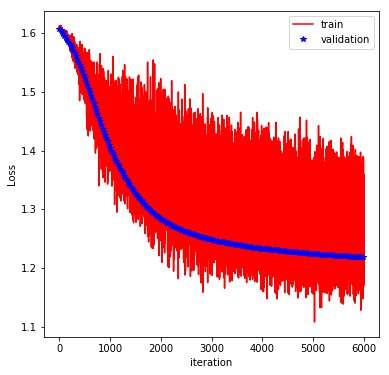

In [24]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 25 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

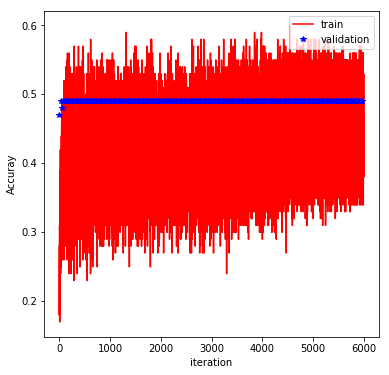

In [28]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 25 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [30]:
test_acc = []
#use model 
with tf.Session(graph=graph) as sess:
    # Restore 
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1,
                initial_state: test_state}
        
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        #print(test_state)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints\credit-grade-cnn-lstm.ckpt
Test accuracy: 0.500000
